#Code for ViViT model [[paper]](https://arxiv.org/abs/2103.15691)


## Imports and Global declarations

In [1]:
# Imports

import torch
from torch import nn, einsum
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
import torchvision as tv
from torch.utils.data import random_split, DataLoader,Dataset

import os
import time
import random
import math

# !pip install einops icecream
import decord
import numpy as np
import gc
from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from PIL import Image
from tqdm.notebook import tqdm
from icecream import ic
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set device
device ='cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
# Instantiate tensorboard writer
#tb_writer = SummaryWriter()

## DataLoader for UCF101 dataset 

In [4]:
# dataset params
frames_per_clip = 8
dataset_dir="./ucf/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist"
video_dir = "./ucf/UCF101/UCF-101"

In [5]:
# Dataset Class
class UCFDataset(torch.utils.data.Dataset):
    """
    Dataset Class for reading UCF101 dataset  
    
    Args:
        dataset_dir: (str) - root directory of dataset
        subset: (str) - train or test subset
        video_list_file: (str) - file name containing list of video names 
        frames_per_clip: (int) - number of frames to be read in every video clip [default:16]
    """

    def __init__(self, dataset_dir, subset, video_list_file, frames_per_clip=16):
        super().__init__()
        self.dataset_dir = dataset_dir
        self.video_dir = video_dir
        self.subset=subset
        self.video_list_file = video_list_file
        self.video_list = []
        self.labels = []
        self.indices = []

        for i in [1,2,3]:
            with open(f'{dataset_dir}/{video_list_file}{str(i)}.txt') as video_names_file:
                if self.subset=="train":
                    tempvideo_list,templabels = zip(*(files[:-1].split() for files in video_names_file.readlines()))
                    self.video_list += tempvideo_list
                    self.labels += templabels
                else:
                    tempvideo_list = [files[:-1] for files in video_names_file.readlines()]
                    templabels = [None]
                    self.video_list += tempvideo_list
                    self.labels += templabels
                    # with open(f'{dataset_dir}/classInd.txt') as classIndices:
                    #     values,keys=zip(*(files[:-1].split() for files in classIndices.readlines()))
                    #     tempindices = dict( (k,v) for k,v in zip(keys,values))
                    
            
            #self.indices.append(tempindices)
        

        self.frames_per_clip = frames_per_clip

        self.transform = tv.transforms.Compose([
          #tv.transforms.GaussianBlur(9, sigma=(0.1, 2.0)),
          tv.transforms.Resize(256,interpolation=tv.transforms.InterpolationMode.BICUBIC),
          tv.transforms.CenterCrop(224),
          tv.transforms.ToTensor(),
          tv.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ])

    def __len__(self):
        return len(self.video_list)

    def __getitem__(self, idx):
        videoname = f'{self.video_list[idx]}'
        vid = decord.VideoReader(f'{self.video_dir}/{videoname}', ctx=decord.cpu(0))
        nframes = len(vid)

        # if number of frames of video is less than frames_per_clip, repeat the frames
        if nframes <= self.frames_per_clip:
            idxs = np.arange(0, self.frames_per_clip).astype(np.int32)
            idxs[nframes:] %= nframes

        # else if frames_per_clip is greater, sample uniformly seperated frames
        else:
            idxs = np.linspace(0, nframes-1, self.frames_per_clip)
            idxs = np.round(idxs).astype(np.int32)

        imgs = []
        for k in idxs:
            frame = Image.fromarray(vid[k].asnumpy())
            frame = self.transform(frame)
            imgs.append(frame)
        imgs = torch.stack(imgs)

        # if its train subset, return both the frames and the label 
        if self.subset=="train":
            label = int(self.labels[idx]) - 1    
        # else, for test subset, read the label index
        else:
            classttl = {}
            with open(f'{dataset_dir}/classInd.txt') as clsidx:
                
                classttl = {v:int(k) for k, v in (l.split() for l in clsidx)}

            clsname = videoname.split('/')[0]
            label= classttl[clsname] -1
        return imgs,label

In [6]:
#Instantiate and create train-val-test split

train_val_data = UCFDataset( dataset_dir = dataset_dir, subset="train", video_list_file="trainlist0",frames_per_clip=frames_per_clip)

train_len=int(0.85*len(train_val_data))
train_val_split = [ train_len, len(train_val_data) - train_len ] 

train_data , val_data = random_split(train_val_data,train_val_split)
test_data = UCFDataset( dataset_dir = dataset_dir, subset="test", video_list_file="testlist0" ,frames_per_clip=frames_per_clip)

print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")


Train samples: 24434
Validation samples: 4313
Test samples: 11213


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([8, 3, 224, 224])
17


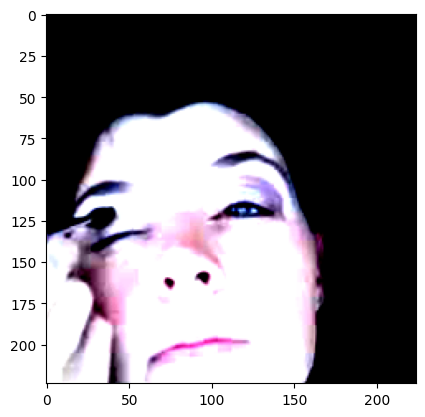

In [7]:
#example frame from a random video to check if dataloader's working properly
plt.imshow(((test_data[35][0][0].permute(1,2,0)*255).int()).numpy())
print(train_data[35][0].shape)  #Size([8, 3, 224, 224])
print(train_data[35][1])        # label

In [8]:
# data loading params
batch_size = 64
test_batch_size = 1
num_workers = 8
pin_memory = True
num_classes=101

In [9]:
# Dataloaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=test_batch_size)

## Model definition

In [10]:
class MLP(nn.Module):
    """
    Builds a simple feed forward network
    
    Args:
        dim: (int) - inner dimension of| embeddings 
        inner_dim: (int) - dimension of transformer head  
    
    """

    def __init__(self, dim, inner_dim,n_class,encoder):     #dim would be the output image feature from dinov2
                                                        
        super().__init__()
        # mlp with GELU activation function
        self.encoder = encoder
        #self.adapter = adapter
        # self.preprocess = nn.Sequential(
        #     nn.Conv2d(in_channels=3,out_channels=width,kernel_size=patch_size,stride=patch_size,bias=False)
            
        # )
        self.mlp = nn.Sequential(
            #nn.Linear(dim, inner_dim),
            #nn.GELU(),
            #nn.Dropout(0.5),
            #nn.Linear(inner_dim, inner_dim),
            #nn.GELU(),
            nn.Linear(dim, n_class),
            #nn.Dropout(0.5)
        )

    def forward(self, x):
        # x is [256,8,3,224,224]
        
        #print('x shape is',x.shape)
        # avg = []
        
        # for i in range(8):
        #     xi = x[:,i,:]
            
        #     #encode x to [8,384]
        #     e = []
        #     with torch.no_grad():
        #         # features_dict = self.encoder.forward_features(xi)
        #         # e = features_dict['x_norm_patchtokens']
        #         e = self.encoder(xi).reshape(x.shape[0],1,384)
        #     print('e shape ',e.shape)   #256,1,384
        #     avg.append(e)
        # avg = torch.cat(avg,dim=1)    
        
               
        #avg = reduce(avg, "f t c -> f c",'mean')        #[16,384]   (b, l)
        B,T,C,H,W = x.shape
        #x = self.adapter(x,T)

        with torch.no_grad():    
            
            x = x.reshape(B*T,C,H,W) # b c t h w -> b t c h w -> b*t c h w
            #print('x shape is',x.shape)
            output = self.encoder(x)
            output = output.reshape(B,T,-1) # b*t d -> b t d
            avg = output.mean(dim=-2) # b t d -> b d
        #output = linear_classifier(output) # b d -> b l
        #print(avg.shape)
        
        return self.mlp(avg)

In [11]:
class Adapter(nn.Module):

    def __init__(self, in_channels, adapter_channels, kernel_size):
        super().__init__()
        
        self.fc1 = nn.Linear(in_channels, adapter_channels)
        self.conv = nn.Conv3d(
            adapter_channels, adapter_channels,
            kernel_size=kernel_size,
            stride=(1, 1, 1),
            padding=tuple(x // 2 for x in kernel_size),
            groups=adapter_channels,
        )
        self.fc2 = nn.Linear(adapter_channels, in_channels)
       
        nn.init.constant_(self.conv.weight, 0.)
        nn.init.constant_(self.conv.bias, 0.)
        nn.init.constant_(self.fc1.bias, 0.)
        nn.init.constant_(self.fc2.bias, 0.)

    def forward(self, x, T):
        x = rearrange(x,'b t c h w-> (b t) (h w) c',t=T)
        BT, L, C = x.size()
        #print(x.size())
        B = BT // T
        Ca = self.conv.in_channels      #adapter_channels
        H = W = round(math.sqrt(L))
        assert L == H * W       #was L-1, without concat, should be L
        x_id = x
        #x = x[:, 1:, :]
        print('x shape b',x.size())
        x = self.fc1(x)
        print('x shape',x.size())
        x = x.view(B, T, H, W, Ca).permute(0, 4, 1, 2, 3).contiguous()

        cudnn_enabled = torch.backends.cudnn.enabled
        torch.backends.cudnn.enabled = cudnn_enabled and True
        x = self.conv(x)
        torch.backends.cudnn.enabled = cudnn_enabled

        x = x.permute(0, 2, 3, 4, 1).contiguous().view(BT, L, Ca)
        x = self.fc2(x)
        x_id += x
        print(x_id.size())
        return x_id
    
class LayerNorm(nn.LayerNorm):
    """Subclass torch's LayerNorm to handle fp16."""

    def forward(self, x: torch.Tensor):
        orig_type = x.dtype
        ret = super().forward(x.type(torch.float32))
        return ret.type(orig_type)

In [12]:
#instantiate model and plot on tensorboard
#model = ViViT(image_size=224, patch_size=16, num_classes=num_classes, frames_per_clip=frames_per_clip)
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')  #,force_reload=True
dinov2_vits14.to(device)
for param in dinov2_vits14.parameters():
    param.requires_grad= False
for i in range(12):
    #dinov2_vits14.blocks[i].add_module('ln',nn.LayerNorm(384))
    dinov2_vits14.blocks[i].add_module('fc1',nn.Linear(384, 384, bias=True))
    dinov2_vits14.blocks[i].add_module('conv',nn.Conv3d(384, 384, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), groups=384))
    dinov2_vits14.blocks[i].add_module('fc2',nn.Linear(384, 384, bias=True))
#adapter = Adapter(768,384,(3,1,1))
#adapter.to(device)
model = MLP(384,512,101,dinov2_vits14)
#frames, _ = next(iter(train_loader))
#tb_writer.add_graph(model, frames)
model.to(device)

Using cache found in /home/z3qian/.cache/torch/hub/facebookresearch_dinov2_main


MLP(
  (encoder): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
        (

In [13]:
# import torchvision.models as models
# from torch.autograd import Variable

# resnet152 = models.resnet152(pretrained=True)
# modules=list(resnet152.children())[:-1]
# resnet152=nn.Sequential(*modules)
# for p in resnet152.parameters():
#     p.requires_grad = False

# img = torch.Tensor(1,3, 224, 224).normal_() # random image
# img_var = Variable(img) # assign it to a variable
# features_var = resnet152(img_var) # get the output from the last hidden layer of the pretrained resnet
# features = features_var.data 

# model = MLP(2048,512,101,resnet152)
# #frames, _ = next(iter(train_loader))
# #tb_writer.add_graph(model, frames)
# model.to(device)

## Training utils 

In [14]:
# training hyper-params
lr=0.01
epochs = 5

In [15]:
# define the loss and optimizers
loss_criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, weight_decay=0,lr=lr)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1_000_00, eta_min=0)
#optimizer = torch.optim.Adam(model.parameters(),lr)
optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=0.9,weight_decay=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.95)


In [16]:
# training step for every epoch
def train_step(loader,epoch,):
    
    model.train()
    # model.encoder.eval()
    total_epoch_loss=0
    
    for batch_id, (video_data,labels) in enumerate(loader):

        # video_data,labels = video_data.to(device), labels.to(device)
        video_data,labels = video_data.to(device), labels.to(device)
        #print(video_data.shape)     [32, 8, 3, 224, 224])      B,T,C,H,W
                                                                #[BT,HW,C]
        optimizer.zero_grad()
        
        prediction = model(video_data)

        loss = loss_criterion(prediction,labels)
        total_epoch_loss += loss.item()

        loss.backward()
        
        optimizer.step()
        corrects = (torch.argmax(prediction,dim=1)==labels).sum()
        bacc = corrects/batch_size
        del video_data
        del labels

        gc.collect()
        
        #tb_writer.add_scalar("Train/Loss",loss.item(),((len(loader))*(epoch-1))+batch_id)
        
        
        print(f"\n[Train Epoch]: {epoch} Train Loss: {loss.item()}, Batch Acc is {bacc.item()}")

    return total_epoch_loss

In [17]:
# validation step for every epoch
def val_step(loader,epoch=None):

    model.eval()
    total_loss=0
    corrects=0
    
    with torch.no_grad():
        for batch_id, (video_data,labels) in enumerate(loader):

            video_data,labels = (video_data).to(device), labels.to(device)

            prediction = model(video_data)
            
            loss = loss_criterion(prediction,labels)
            total_loss += loss.item()
            corrects+= (torch.argmax(prediction,dim=1)==labels).sum()
    
    accuracy = corrects/(len(loader)*batch_size)
    
    print(f"\n[Val Epoch]: {epoch} , Accuracy: {accuracy}, Valid Loss: {loss.item()}")
    #tb_writer.add_scalar("Validation/Loss",loss.item(),epoch)
    #tb_writer.add_scalar("Validation/Accuracy",accuracy,epoch)

    return accuracy

## Train Loop

In [18]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

encoder.blocks.0.fc1.weight
encoder.blocks.0.fc1.bias
encoder.blocks.0.conv.weight
encoder.blocks.0.conv.bias
encoder.blocks.0.fc2.weight
encoder.blocks.0.fc2.bias
encoder.blocks.1.fc1.weight
encoder.blocks.1.fc1.bias
encoder.blocks.1.conv.weight
encoder.blocks.1.conv.bias
encoder.blocks.1.fc2.weight
encoder.blocks.1.fc2.bias
encoder.blocks.2.fc1.weight
encoder.blocks.2.fc1.bias
encoder.blocks.2.conv.weight
encoder.blocks.2.conv.bias
encoder.blocks.2.fc2.weight
encoder.blocks.2.fc2.bias
encoder.blocks.3.fc1.weight
encoder.blocks.3.fc1.bias
encoder.blocks.3.conv.weight
encoder.blocks.3.conv.bias
encoder.blocks.3.fc2.weight
encoder.blocks.3.fc2.bias
encoder.blocks.4.fc1.weight
encoder.blocks.4.fc1.bias
encoder.blocks.4.conv.weight
encoder.blocks.4.conv.bias
encoder.blocks.4.fc2.weight
encoder.blocks.4.fc2.bias
encoder.blocks.5.fc1.weight
encoder.blocks.5.fc1.bias
encoder.blocks.5.conv.weight
encoder.blocks.5.conv.bias
encoder.blocks.5.fc2.weight
encoder.blocks.5.fc2.bias
encoder.blocks.6

In [19]:
# Driving train test loop
for epoch in tqdm(range(1,epochs+1)):
    train_step(train_loader, epoch)
    val_step(val_loader, epoch)
    #scheduler.step()
    torch.save(model.state_dict(),"resnet_model.pth")

  0%|          | 0/5 [00:00<?, ?it/s]


[Train Epoch]: 1 Train Loss: 5.415647029876709, Batch Acc is 0.0

[Train Epoch]: 1 Train Loss: 5.702697277069092, Batch Acc is 0.0

[Train Epoch]: 1 Train Loss: 4.9019575119018555, Batch Acc is 0.03125

[Train Epoch]: 1 Train Loss: 4.9359869956970215, Batch Acc is 0.0625

[Train Epoch]: 1 Train Loss: 4.732161998748779, Batch Acc is 0.0625

[Train Epoch]: 1 Train Loss: 4.053545951843262, Batch Acc is 0.109375

[Train Epoch]: 1 Train Loss: 4.019776344299316, Batch Acc is 0.125

[Train Epoch]: 1 Train Loss: 3.969655752182007, Batch Acc is 0.171875

[Train Epoch]: 1 Train Loss: 3.4254684448242188, Batch Acc is 0.265625

[Train Epoch]: 1 Train Loss: 3.3211309909820557, Batch Acc is 0.328125

[Train Epoch]: 1 Train Loss: 3.0150067806243896, Batch Acc is 0.328125

[Train Epoch]: 1 Train Loss: 2.6722981929779053, Batch Acc is 0.359375

[Train Epoch]: 1 Train Loss: 2.3366036415100098, Batch Acc is 0.453125

[Train Epoch]: 1 Train Loss: 2.3261570930480957, Batch Acc is 0.46875

[Train Epoch]: 1

KeyboardInterrupt: 

In [ ]:
import torchvision.models as models
from torch.autograd import Variable

resnet152 = models.resnet152(pretrained=True)
modules=list(resnet152.children())[:-1]
resnet152=nn.Sequential(*modules)
for p in resnet152.parameters():
    p.requires_grad = False

model = MLP(2048,512,101,resnet152)
a = torch.load('resnet_model.pth')
print(type(a))
#model.load_state_dict(torch.load('resnet_model.pth'))
model = torch.load('resnet_model.pth')
model.to(device)

/home/z3qian/miniconda3/envs/dinov2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z3qian/miniconda3/envs/dinov2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<class '__main__.MLP'>


MLP(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256,

## Testing

In [20]:
# test the trained model  
def test_model(loader):

    model.eval()
    corrects=0
    total_loss = 0
    with torch.no_grad():
        for batch_id, (input_data,labels) in enumerate(loader):
            
            input_data = input_data.to(device)
            
            labels = labels.to(device)
            prediction = model(input_data)
            loss = loss_criterion(prediction,labels)
            total_loss += loss.item()
            corrects+= (torch.argmax(prediction,dim=1)==labels).sum()
    
    accuracy = corrects/(len(loader)*test_batch_size)
    print(f"Test Accuracy: {accuracy}, Test Loss: {total_loss}")

    return accuracy

In [21]:

test_model(test_loader)

Test Accuracy: 0.9969677925109863, Test Loss: 831.5311852202867


tensor(0.9970, device='cuda:0')

## Visualize results on tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs/ 